# Download Equity Price Data

Fetches adjusted close prices for equity names used in correlation analysis.

**Tickers:**
- Financials: JPM, BAC, C, GS, MS
- Energy: XOM, CVX
- Telecom: T, VZ
- Aerospace: BA
- Tech: IBM

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path

In [3]:
# Ticker definitions with metadata
TICKERS = {
    # Financials
    'JPM': {'name': 'JPMorgan Chase & Co.', 'sector': 'Financials'},
    'BAC': {'name': 'Bank of America', 'sector': 'Financials'},
    'C': {'name': 'Citigroup', 'sector': 'Financials'},
    'GS': {'name': 'Goldman Sachs', 'sector': 'Financials'},
    'MS': {'name': 'Morgan Stanley', 'sector': 'Financials'},
    # Energy
    'XOM': {'name': 'Exxon Mobil', 'sector': 'Energy'},
    'CVX': {'name': 'Chevron', 'sector': 'Energy'},
    # Telecom
    'T': {'name': 'AT&T', 'sector': 'Telecom'},
    'VZ': {'name': 'Verizon', 'sector': 'Telecom'},
    # Aerospace
    'BA': {'name': 'Boeing', 'sector': 'Aerospace'},
    # Tech
    'IBM': {'name': 'IBM', 'sector': 'Tech'},
}

In [4]:
# Date range: last 2 years
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=2*365)

print(f"Date range: {START_DATE.date()} to {END_DATE.date()}")

Date range: 2024-01-21 to 2026-01-20


In [5]:
# Download data
ticker_list = list(TICKERS.keys())

print(f"Downloading {len(ticker_list)} tickers...")
data = yf.download(
    ticker_list,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True,
    progress=True
)

# Extract close prices (adjusted)
prices = data['Close']
print(f"\nDownloaded {len(prices)} trading days")

[*********************100%***********************]  11 of 11 completed


Downloaded 500 trading days


In [6]:
# Check for missing data
print("Missing values per ticker:")
print(prices.isnull().sum())

Missing values per ticker:
Ticker
BA     0
BAC    0
C      0
CVX    0
GS     0
IBM    0
JPM    0
MS     0
T      0
VZ     0
XOM    0
dtype: int64


In [7]:
# Convert to long format
# columns: date, reference_entity, ticker, sector, adjusted_close

rows = []
for date, row in prices.iterrows():
    for ticker, price in row.items():
        if pd.notna(price):
            rows.append({
                'date': date.strftime('%Y-%m-%d'),
                'reference_entity': TICKERS[ticker]['name'],
                'ticker': ticker,
                'sector': TICKERS[ticker]['sector'],
                'adjusted_close': round(price, 2)
            })

df = pd.DataFrame(rows)
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

print(f"Total rows: {len(df):,}")
print(f"\nShape: {df.shape}")
df.head(10)

Total rows: 5,500

Shape: (5500, 5)


,date,reference_entity,ticker,sector,adjusted_close
0,2024-01-22,Boeing,BA,Aerospace,214.93
1,2024-01-23,Boeing,BA,Aerospace,211.50
2,2024-01-24,Boeing,BA,Aerospace,214.13
3,2024-01-25,Boeing,BA,Aerospace,201.88
4,2024-01-26,Boeing,BA,Aerospace,205.47
5,2024-01-29,Boeing,BA,Aerospace,205.19
6,2024-01-30,Boeing,BA,Aerospace,200.44
7,2024-01-31,Boeing,BA,Aerospace,211.04
8,2024-02-01,Boeing,BA,Aerospace,209.81
9,2024-02-02,Boeing,BA,Aerospace,209.38


In [8]:
# Summary by ticker
summary = df.groupby(['ticker', 'reference_entity', 'sector']).agg(
    start_date=('date', 'min'),
    end_date=('date', 'max'),
    n_obs=('date', 'count'),
    min_price=('adjusted_close', 'min'),
    max_price=('adjusted_close', 'max'),
    last_price=('adjusted_close', 'last')
).reset_index()

print("Summary by ticker:")
display(summary)

Summary by ticker:


,ticker,reference_entity,sector,start_date,end_date,n_obs,min_price,max_price,last_price
0,BA,Boeing,Aerospace,2024-01-22,2026-01-16,500,136.59,247.74,247.68
1,BAC,Bank of America,Financials,2024-01-22,2026-01-16,500,31.02,57.25,52.97
2,C,Citigroup,Financials,2024-01-22,2026-01-16,500,49.57,123.30,118.04
3,CVX,Chevron,Energy,2024-01-22,2026-01-16,500,129.22,167.24,166.26
4,GS,Goldman Sachs,Financials,2024-01-22,2026-01-16,500,361.48,975.86,962.00
5,IBM,IBM,Tech,2024-01-22,2026-01-16,500,156.11,314.98,305.67
6,JPM,JPMorgan Chase & Co.,Financials,2024-01-22,2026-01-16,500,161.89,334.61,312.47
7,MS,Morgan Stanley,Financials,2024-01-22,2026-01-16,500,79.58,191.23,189.09
8,T,AT&T,Telecom,2024-01-22,2026-01-16,500,14.81,28.96,23.49
9,VZ,Verizon,Telecom,2024-01-22,2026-01-16,500,34.39,43.54,38.91


In [9]:
# Save to CSV
output_path = Path('equity_prices.csv')
df.to_csv(output_path, index=False)
print(f"Saved to: {output_path.absolute()}")

Saved to: d:\cqf-cds-pricing\data\real\equity_prices.csv


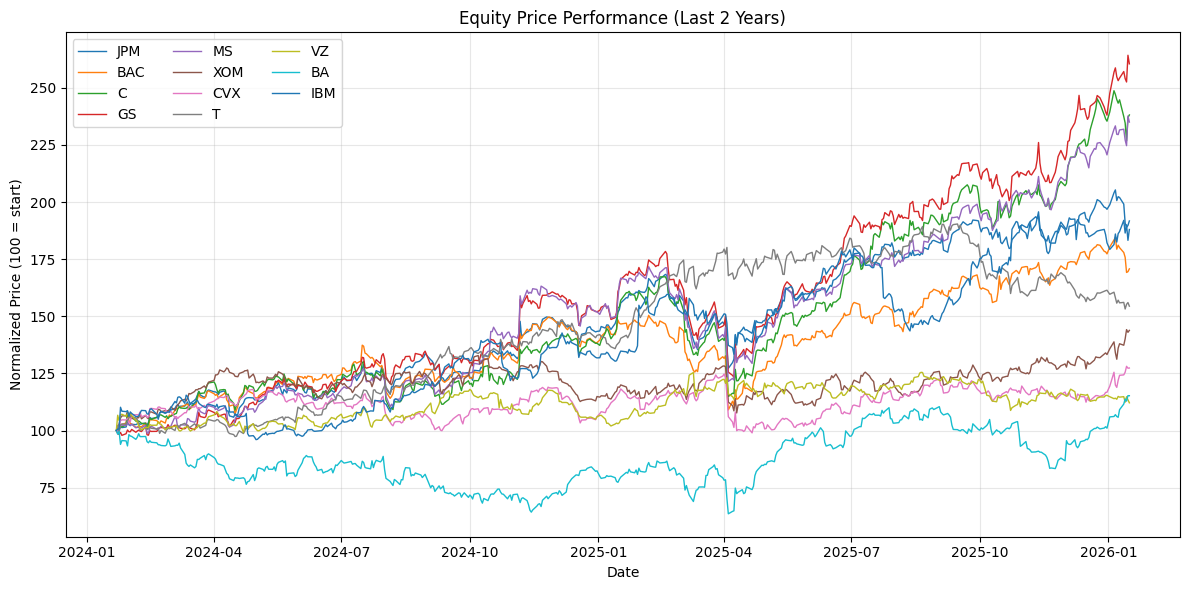

In [ ]:
# Quick visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

for ticker in ticker_list:
    subset = df[df['ticker'] == ticker]
    # Normalize to 100 at start for comparison
    normalized = subset['adjusted_close'] / subset['adjusted_close'].iloc[0] * 100
    ax.plot(pd.to_datetime(subset['date']), normalized, label=ticker, linewidth=1)

ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price (100 = start)')
ax.set_title('Equity Price Performance (Last 2 Years)')
ax.legend(loc='upper left', ncol=3)
ax.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('equity_prices_chart.png', dpi=150)
plt.show()